In [100]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s185231/HPC3D_project')

In [101]:
sample_size = 5

In [102]:
def get_thickness(bin_sample, mask_sample, pixel_size):
    # get the local thickness
    local_thickness = lt.local_thickness(bin_sample, mask=mask_sample)
    thickness_true = 2*local_thickness
    # we want it in real world units
    thickness_true *= pixel_size

    return thickness_true

def get_statistics(bin_sample, mask_sample, pixel_size):
    # get ratio
    ratio = np.sum(bin_sample)/np.sum(mask_sample)

    # get the local thickness
    thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
    thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

    # get the mean thickness
    mean_thickness_stone = np.mean(thickness_stone[thickness_stone > 0])
    mean_thickness_bubbles = np.mean(thickness_bubbles[thickness_bubbles > 0])

    # get median thickness
    median_thickness_stone = np.median(thickness_stone[thickness_stone > 0])
    median_thickness_bubbles = np.median(thickness_bubbles[thickness_bubbles > 0])

    # get max thickness
    max_thickness_stone = np.max(thickness_stone)
    max_thickness_bubbles = np.max(thickness_bubbles)

    # get variance
    var_thickness_stone = np.var(thickness_stone[thickness_stone > 0])
    var_thickness_bubbles = np.var(thickness_bubbles[thickness_bubbles > 0])


    dict = {'ratio': ratio, 'mean_thickness_stone': mean_thickness_stone, 'mean_thickness_bubbles': mean_thickness_bubbles, 'median_thickness_stone': median_thickness_stone, 'median_thickness_bubbles': median_thickness_bubbles, 'max_thickness_stone': max_thickness_stone, 'max_thickness_bubbles': max_thickness_bubbles, 'var_thickness_stone': var_thickness_stone, 'var_thickness_bubbles': var_thickness_bubbles}
    
    return dict


def extract_samples(mask, pixels_per_mm, mm_per_grid=5, discard_threshold=0.5):
    """
    Extracts a grid of samples from a mask where each sample has a meaningful amount of data.

    Args:
        mask: A 3D numpy array representing the mask.
        pxels_per_mm: The number of pixels per mm in the volume.
        mm_per_grid: The physical size of each grid element.
        discard_threshold: The threshold for discarding samples based on the mask.

    Returns:
        A list of dicts that map the indices of the extracted samples
    """
    samples = []
    for i in range(0, mask.shape[0], int(mm_per_grid * pixels_per_mm)):
        for j in range(0, mask.shape[1], int(mm_per_grid * pixels_per_mm)):
            for k in range(0, mask.shape[2], int(mm_per_grid * pixels_per_mm)):
                if np.mean(mask[i:i + int(mm_per_grid * pixels_per_mm), j:j + int(mm_per_grid * pixels_per_mm), k:k + int(mm_per_grid * pixels_per_mm)]) > discard_threshold:
                    samples.append({'i': (i, i + int(mm_per_grid * pixels_per_mm)),
                                    'j': (j, j + int(mm_per_grid * pixels_per_mm)),
                                    'k': (k, k + int(mm_per_grid * pixels_per_mm))})
    return samples

def apply_grid(volume, grid_dict):
    """
    Extracts a sliced volume based on the grid_dict.
    
    volume: A 3D numpy array representing the volume.
    grid_dict: A dict containing the indices of the volume to extract as given in extract_samples
    
    """
    i, i_mark = grid_dict['i']
    j, j_mark = grid_dict['j']
    k, k_mark = grid_dict['k']

    return volume[i:i_mark, j:j_mark, k:k_mark]
    

In [103]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01'
stone = 'island_ny'
file_name = 'lavasten_Island_ny_LFOV-80kV-LE2-1.8s-21.8micro_recon.txm'
absolute_path = os.path.join(folder_path, stone, file_name)
all_data_ny = dxchange.reader.read_txm(absolute_path)

stone = 'island_gammel'
file_name = 'lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.txm'
absolute_path = os.path.join(folder_path, stone, file_name)
all_data_gl = dxchange.reader.read_txm(absolute_path)

stone = 'madagascar'
file_name = 'lavasten_Madagascar_LFOV-80kV-LE2-1.5s-42micro_recon.txm'
absolute_path = os.path.join(folder_path, stone, file_name)
all_data_ma = dxchange.reader.read_txm(absolute_path)

In [104]:
stone = 'island_ny'
file_name = 'bin_data_downsampled.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
bin_data_ny = tifffile.imread(absolute_path)

file_name = 'mask_downsampled.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
mask_ny = tifffile.imread(absolute_path)

stone = 'island_gammel'
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
bin_data_gl = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
mask_gl = tifffile.imread(absolute_path)

stone = 'madagascar'
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
bin_data_ma = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
mask_ma = tifffile.imread(absolute_path)

In [105]:
bin_data_ny = bin_data_ny.astype(np.uint8)
mask_ny = mask_ny.astype(np.uint8)

In [106]:
pixel_size_ny = all_data_ny[1]['pixel_size']*2
print(pixel_size_ny)
img_shape_ny = bin_data_ny.shape
print(img_shape_ny)
img_shape_array = np.array(img_shape_ny)
total_size_ny = img_shape_array * pixel_size_ny
total_size__mm_ny = total_size_ny/1000
print(total_size__mm_ny)
pixel_size_mm_ny = pixel_size_ny/1000
pixels_per_mm_ny = 1/pixel_size_mm_ny
print(pixels_per_mm_ny)

43.64527130126953
(509, 512, 502)
[22.21544309 22.34637891 21.90992619]
22.911989550879767


In [107]:
pixel_size_gl = all_data_gl[1]['pixel_size']
print(pixel_size_gl)
img_shape_gl = bin_data_gl.shape
print(img_shape_gl)
img_shape_array = np.array(img_shape_gl)
total_size_gl = img_shape_array * pixel_size_gl
total_size__mm_gl = total_size_gl/1000
print(total_size__mm_gl)
pixel_size_mm_gl = pixel_size_gl/1000
pixels_per_mm_gl = 1/pixel_size_mm_gl
print(pixels_per_mm_gl)

45.34814453125
(1017, 1024, 1004)
[46.11906299 46.4365     45.52953711]
22.051618877391707


In [108]:
pixel_size_ma = all_data_ma[1]['pixel_size']
print(pixel_size_ma)
img_shape_ma = bin_data_ma.shape
print(img_shape_ma)
img_shape_array = np.array(img_shape_ma)
total_size_ma = img_shape_array * pixel_size_ma
total_size__mm_ma = total_size_ma/1000
print(total_size__mm_ma)
pixel_size_mm_ma = pixel_size_ma/1000
pixels_per_mm_ma = 1/pixel_size_mm_ma
print(pixels_per_mm_ma)

41.99748992919922
(1018, 1024, 1004)
[42.75344475 43.00542969 42.16547989]
23.810946837199882


In [109]:
print(bin_data_ny.shape, mask_ny.shape)
print(bin_data_gl.shape, mask_gl.shape)
print(bin_data_ma.shape, mask_ma.shape)

(509, 512, 502) (509, 512, 502)
(1017, 1024, 1004) (1017, 1024, 1004)
(1018, 1024, 1004) (1018, 1024, 1004)


In [110]:
print(pixels_per_mm_ny, pixels_per_mm_gl, pixels_per_mm_ma)

22.911989550879767 22.051618877391707 23.810946837199882


In [111]:
grid_list_ny = extract_samples(mask=mask_ny,
                               pixels_per_mm=pixels_per_mm_ny,
                               mm_per_grid=sample_size,
                               discard_threshold=0.33)


print(len(grid_list_ny))

grid_list_gl = extract_samples(mask=mask_gl,
                                 pixels_per_mm=pixels_per_mm_gl,
                                 mm_per_grid=sample_size,
                                 discard_threshold=0.33)

print(len(grid_list_gl))

grid_list_ma = extract_samples(mask=mask_ma,
                                    pixels_per_mm=pixels_per_mm_ma,
                                    mm_per_grid=sample_size,
                                    discard_threshold=0.33)

print(len(grid_list_ma))

11


99
120


In [112]:
#num_samples = min(len(grid_list_ny), len(grid_list_gl), len(grid_list_ma))

# select random samples from the list
#grid_samples_ny = np.random.choice(grid_list_ny, num_samples, replace=False)
#grid_samples_gl = np.random.choice(grid_list_gl, num_samples, replace=False)
#grid_samples_ma = np.random.choice(grid_list_ma, num_samples, replace=False)

grid_samples_ny = grid_list_ny
grid_samples_gl = grid_list_gl
grid_samples_ma = grid_list_ma

#print(len(grid_samples_ny), len(grid_samples_gl), len(grid_samples_ma))

In [113]:
statistics_ny = []
for i, grid_dict in enumerate(grid_samples_ny):
    print(f'Processing sample {i}/{len(grid_samples_ny)}')
    bin_sample = apply_grid(volume=bin_data_ny, grid_dict=grid_dict)
    mask_sample = apply_grid(volume=mask_ny, grid_dict=grid_dict)
    stats = get_statistics(bin_sample, mask_sample, pixel_size_mm_ny)
    statistics_ny.append(stats)

Processing sample 0/11


Processing sample 1/11
Processing sample 2/11
Processing sample 3/11
Processing sample 4/11
Processing sample 5/11
Processing sample 6/11
Processing sample 7/11
Processing sample 8/11
Processing sample 9/11
Processing sample 10/11


In [114]:
statistics_gl = []
for i, grid_dict in enumerate(grid_samples_gl):
    print(f'Processing sample {i}/{len(grid_samples_gl)}')
    bin_sample = apply_grid(volume=bin_data_gl, grid_dict=grid_dict)
    mask_sample = apply_grid(volume=mask_gl, grid_dict=grid_dict)
    stats = get_statistics(bin_sample, mask_sample, pixel_size_mm_gl)
    statistics_gl.append(stats)

Processing sample 0/99


Processing sample 1/99
Processing sample 2/99
Processing sample 3/99
Processing sample 4/99
Processing sample 5/99
Processing sample 6/99
Processing sample 7/99
Processing sample 8/99
Processing sample 9/99
Processing sample 10/99
Processing sample 11/99
Processing sample 12/99
Processing sample 13/99
Processing sample 14/99
Processing sample 15/99
Processing sample 16/99
Processing sample 17/99
Processing sample 18/99
Processing sample 19/99
Processing sample 20/99
Processing sample 21/99
Processing sample 22/99
Processing sample 23/99
Processing sample 24/99
Processing sample 25/99
Processing sample 26/99
Processing sample 27/99
Processing sample 28/99
Processing sample 29/99
Processing sample 30/99
Processing sample 31/99
Processing sample 32/99
Processing sample 33/99
Processing sample 34/99
Processing sample 35/99
Processing sample 36/99
Processing sample 37/99
Processing sample 38/99
Processing sample 39/99
Processing sample 40/99
Processing sample 41/99
Processing sample 42/99
P

In [ ]:
statistics_ma = []
for i, grid_dict in enumerate(grid_samples_ma):
    print(f'Processing sample {i}/{len(grid_samples_ma)}')
    bin_sample = apply_grid(volume=bin_data_ma, grid_dict=grid_dict)
    mask_sample = apply_grid(volume=mask_ma, grid_dict=grid_dict)
    stats = get_statistics(bin_sample, mask_sample, pixel_size_mm_ma)
    statistics_ma.append(stats)

Processing sample 0/11


Processing sample 1/11
Processing sample 2/11
Processing sample 3/11
Processing sample 4/11
Processing sample 5/11
Processing sample 6/11
Processing sample 7/11
Processing sample 8/11
Processing sample 9/11
Processing sample 10/11


In [ ]:
ratios_ny = [stat['ratio'] for stat in statistics_ny]
ratios_gl = [stat['ratio'] for stat in statistics_gl]
ratios_ma = [stat['ratio'] for stat in statistics_ma]

mean_thickness_stone_ny = [stat['mean_thickness_stone'] for stat in statistics_ny]
mean_thickness_stone_gl = [stat['mean_thickness_stone'] for stat in statistics_gl]
mean_thickness_stone_ma = [stat['mean_thickness_stone'] for stat in statistics_ma]

mean_thickness_bubbles_ny = [stat['mean_thickness_bubbles'] for stat in statistics_ny]
mean_thickness_bubbles_gl = [stat['mean_thickness_bubbles'] for stat in statistics_gl]
mean_thickness_bubbles_ma = [stat['mean_thickness_bubbles'] for stat in statistics_ma]

median_thickness_stone_ny = [stat['median_thickness_stone'] for stat in statistics_ny]
median_thickness_stone_gl = [stat['median_thickness_stone'] for stat in statistics_gl]
median_thickness_stone_ma = [stat['median_thickness_stone'] for stat in statistics_ma]

median_thickness_bubbles_ny = [stat['median_thickness_bubbles'] for stat in statistics_ny]
median_thickness_bubbles_gl = [stat['median_thickness_bubbles'] for stat in statistics_gl]
median_thickness_bubbles_ma = [stat['median_thickness_bubbles'] for stat in statistics_ma]

max_thickness_stone_ny = [stat['max_thickness_stone'] for stat in statistics_ny]
max_thickness_stone_gl = [stat['max_thickness_stone'] for stat in statistics_gl]
max_thickness_stone_ma = [stat['max_thickness_stone'] for stat in statistics_ma]

max_thickness_bubbles_ny = [stat['max_thickness_bubbles'] for stat in statistics_ny]
max_thickness_bubbles_gl = [stat['max_thickness_bubbles'] for stat in statistics_gl]
max_thickness_bubbles_ma = [stat['max_thickness_bubbles'] for stat in statistics_ma]

var_thickness_stone_ny = [stat['var_thickness_stone'] for stat in statistics_ny]
var_thickness_stone_gl = [stat['var_thickness_stone'] for stat in statistics_gl]
var_thickness_stone_ma = [stat['var_thickness_stone'] for stat in statistics_ma]

var_thickness_bubbles_ny = [stat['var_thickness_bubbles'] for stat in statistics_ny]
var_thickness_bubbles_gl = [stat['var_thickness_bubbles'] for stat in statistics_gl]
var_thickness_bubbles_ma = [stat['var_thickness_bubbles'] for stat in statistics_ma]



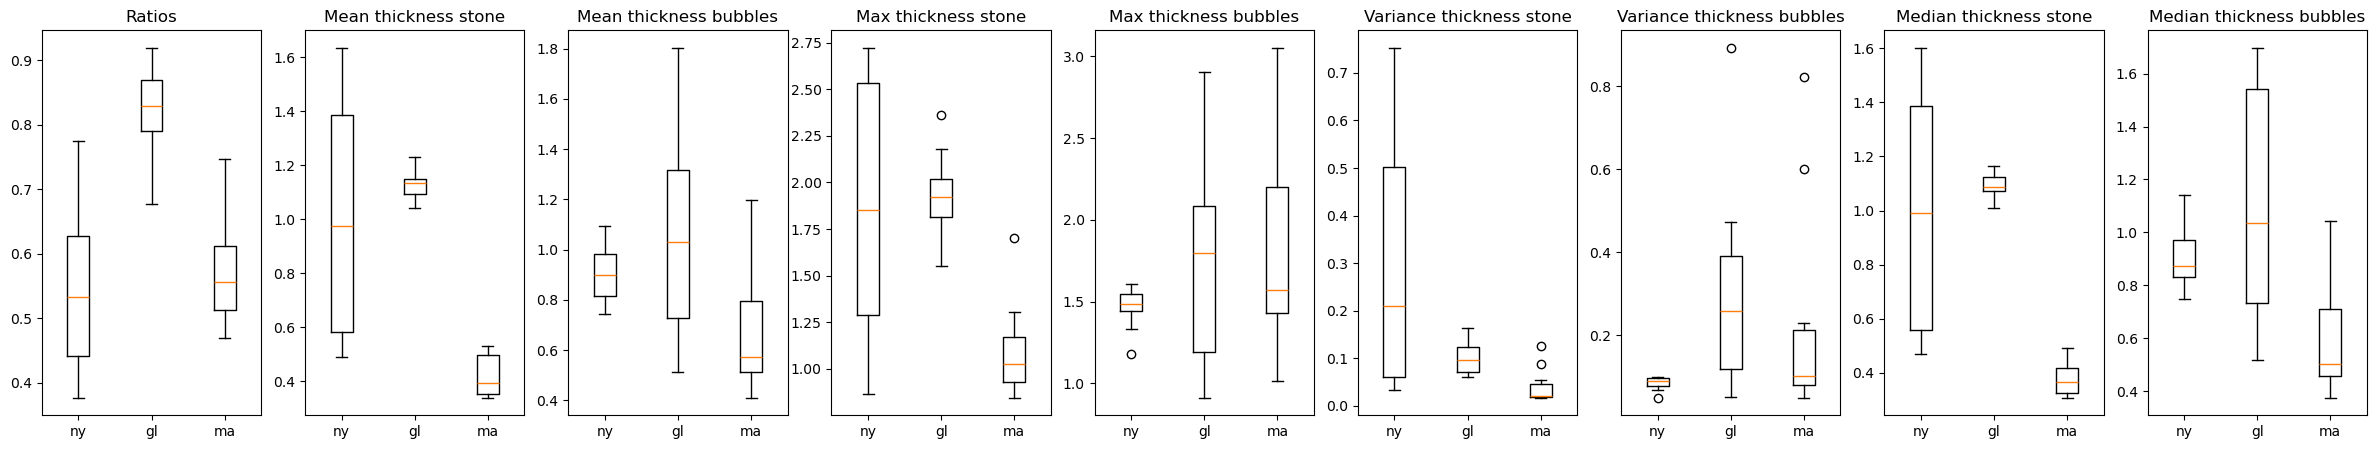

In [ ]:
fig, ax = plt.subplots(1, 9, figsize=(30, 5))
ax[0].boxplot([ratios_ny, ratios_gl, ratios_ma])
ax[0].set_title('Ratios')
ax[0].set_xticklabels(['ny', 'gl', 'ma'])

ax[1].boxplot([mean_thickness_stone_ny, mean_thickness_stone_gl, mean_thickness_stone_ma])
ax[1].set_title('Mean thickness stone')
ax[1].set_xticklabels(['ny', 'gl', 'ma'])

ax[2].boxplot([mean_thickness_bubbles_ny, mean_thickness_bubbles_gl, mean_thickness_bubbles_ma])
ax[2].set_title('Mean thickness bubbles')
ax[2].set_xticklabels(['ny', 'gl', 'ma'])

ax[3].boxplot([max_thickness_stone_ny, max_thickness_stone_gl, max_thickness_stone_ma])
ax[3].set_title('Max thickness stone')
ax[3].set_xticklabels(['ny', 'gl', 'ma'])

ax[4].boxplot([max_thickness_bubbles_ny, max_thickness_bubbles_gl, max_thickness_bubbles_ma])
ax[4].set_title('Max thickness bubbles')
ax[4].set_xticklabels(['ny', 'gl', 'ma'])

ax[5].boxplot([var_thickness_stone_ny, var_thickness_stone_gl, var_thickness_stone_ma])
ax[5].set_title('Variance thickness stone')
ax[5].set_xticklabels(['ny', 'gl', 'ma'])

ax[6].boxplot([var_thickness_bubbles_ny, var_thickness_bubbles_gl, var_thickness_bubbles_ma])
ax[6].set_title('Variance thickness bubbles')
ax[6].set_xticklabels(['ny', 'gl', 'ma'])

ax[7].boxplot([median_thickness_stone_ny, median_thickness_stone_gl, median_thickness_stone_ma])
ax[7].set_title('Median thickness stone')
ax[7].set_xticklabels(['ny', 'gl', 'ma'])

ax[8].boxplot([median_thickness_bubbles_ny, median_thickness_bubbles_gl, median_thickness_bubbles_ma])
ax[8].set_title('Median thickness bubbles')
ax[8].set_xticklabels(['ny', 'gl', 'ma'])

plt.show()

In [ ]:
#%matplotlib widget
%matplotlib inline

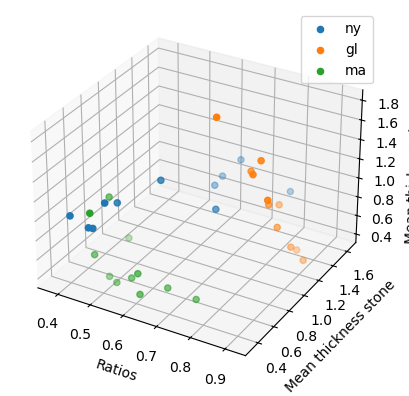

In [ ]:
# make 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ratios_ny, mean_thickness_stone_ny, mean_thickness_bubbles_ny, label='ny')
ax.scatter(ratios_gl, mean_thickness_stone_gl, mean_thickness_bubbles_gl, label='gl')
ax.scatter(ratios_ma, mean_thickness_stone_ma, mean_thickness_bubbles_ma, label='ma')
ax.set_xlabel('Ratios')
ax.set_ylabel('Mean thickness stone')
ax.set_zlabel('Mean thickness bubbles')
plt.legend()
plt.show()


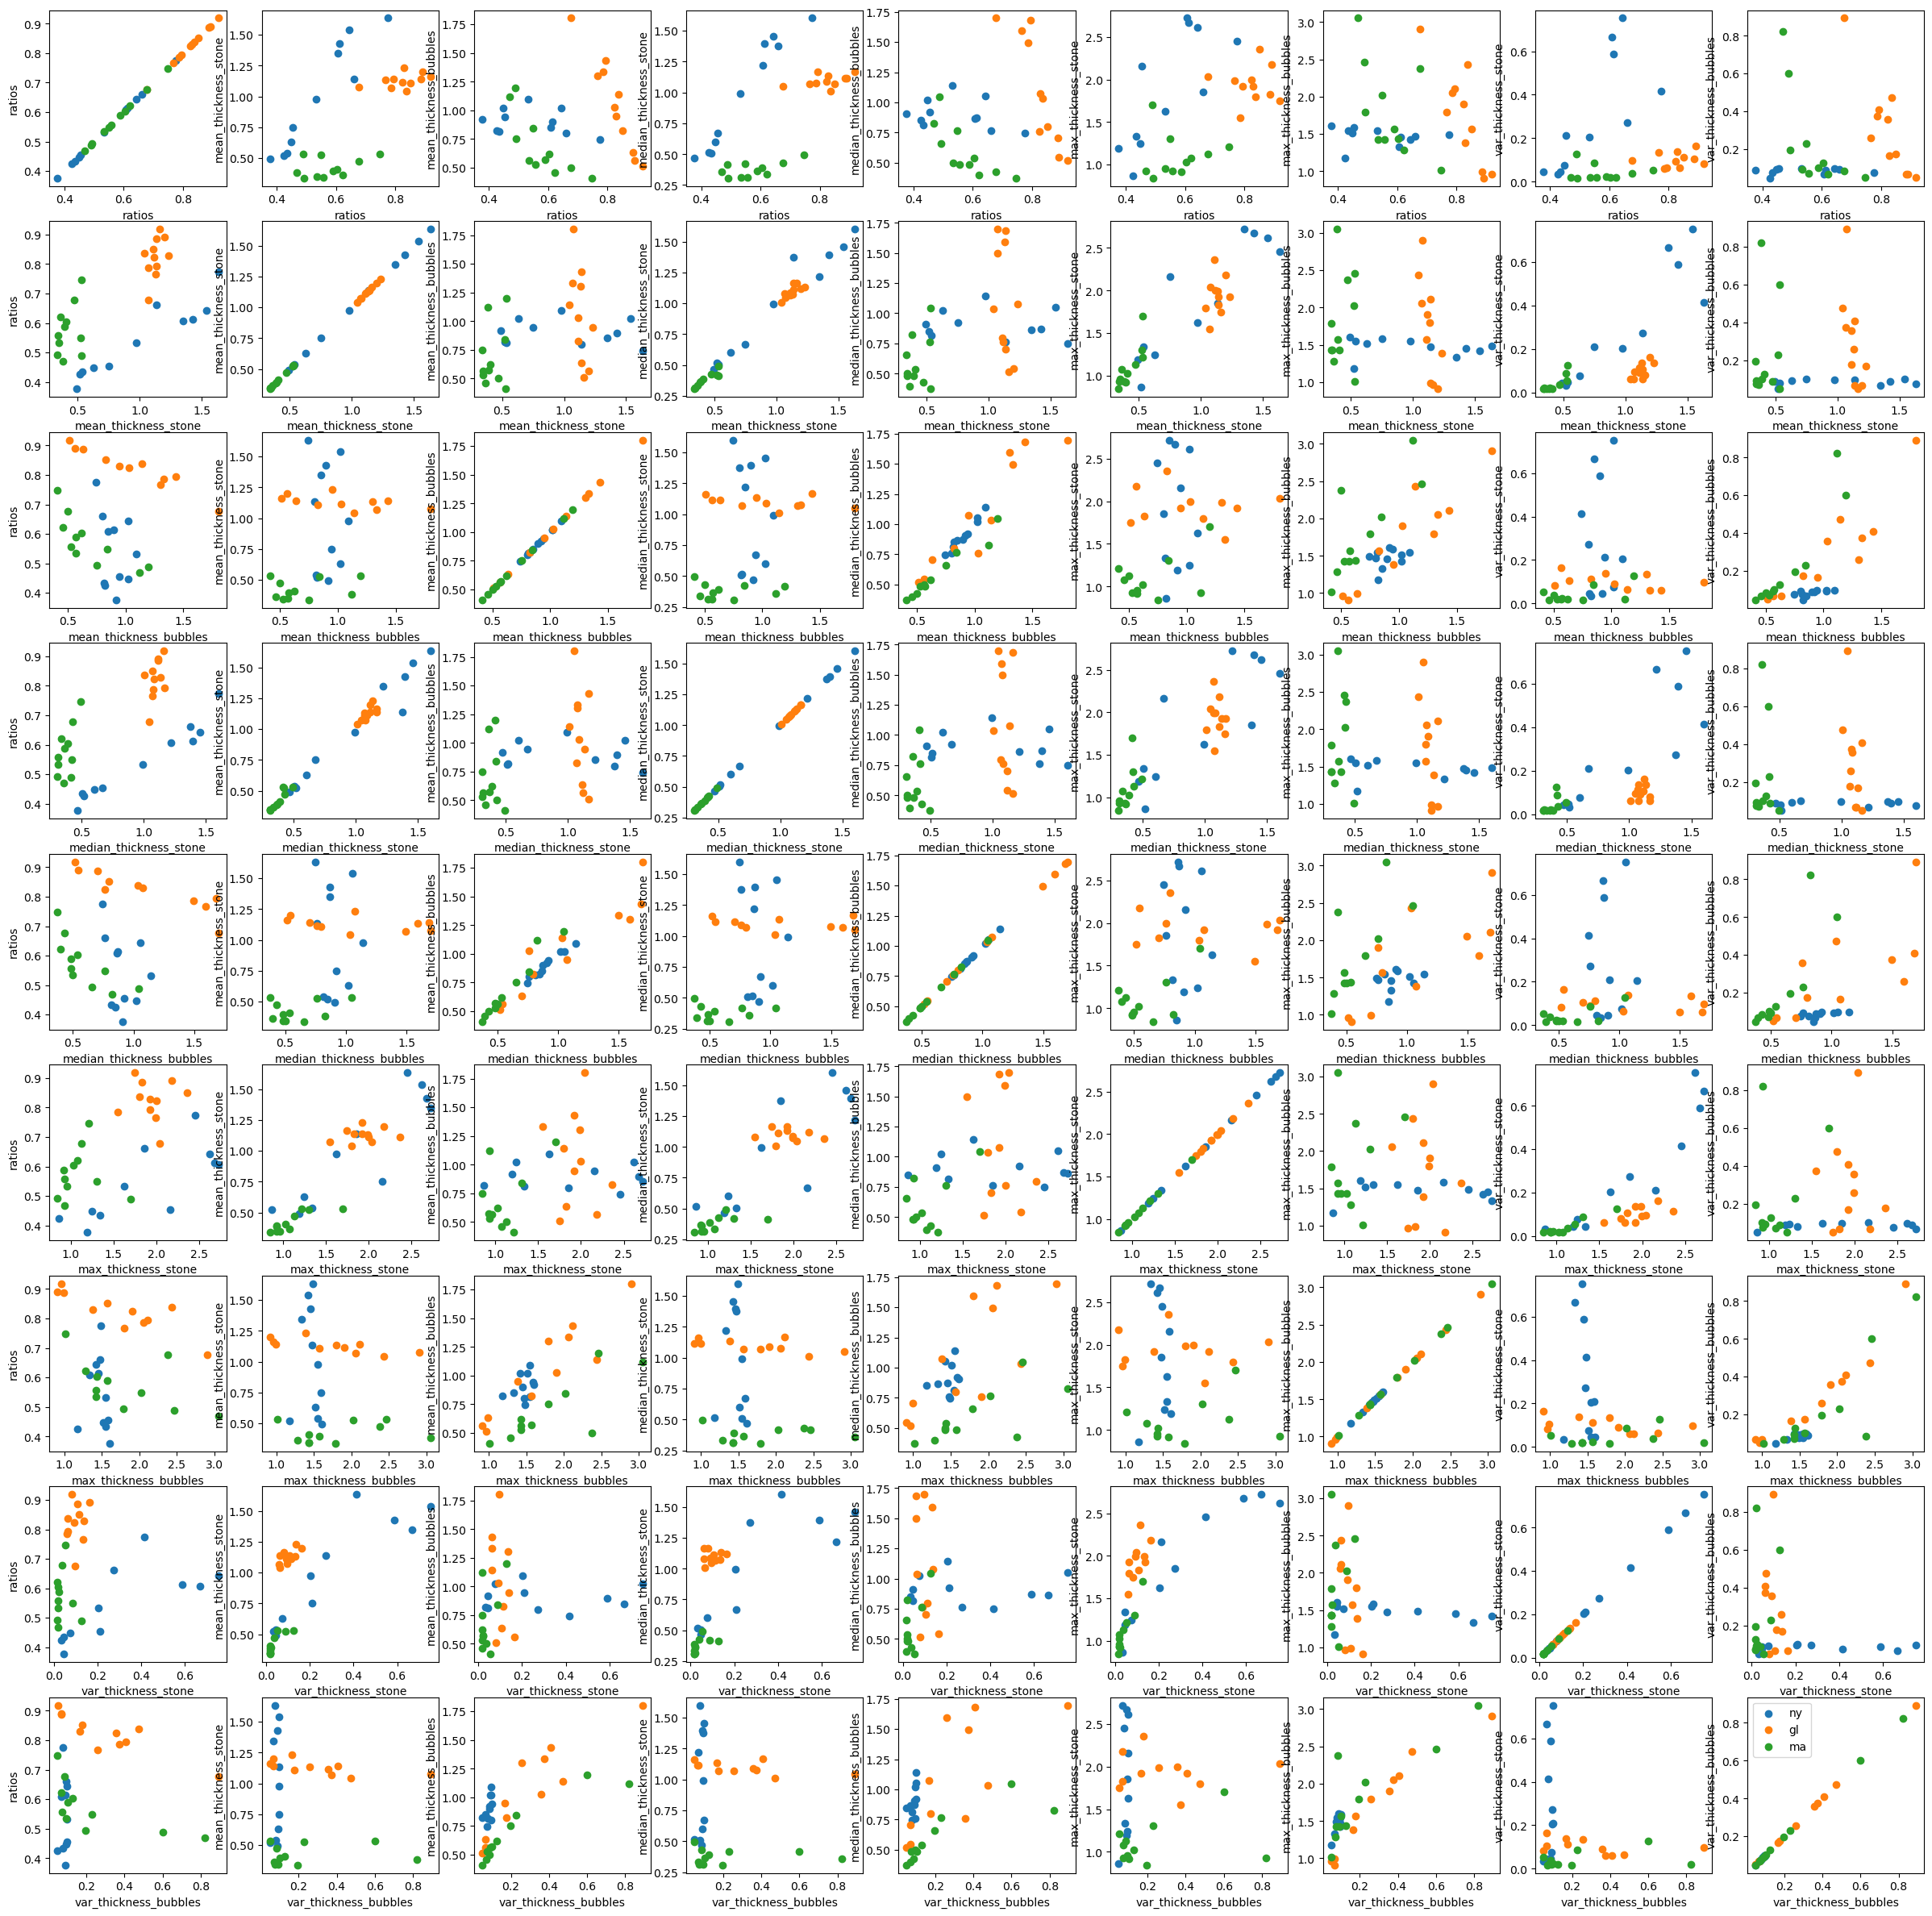

In [ ]:
stats_ny = [ratios_ny, mean_thickness_stone_ny, mean_thickness_bubbles_ny, median_thickness_stone_ny, median_thickness_bubbles_ny, max_thickness_stone_ny, max_thickness_bubbles_ny, var_thickness_stone_ny, var_thickness_bubbles_ny]
stats_gl = [ratios_gl, mean_thickness_stone_gl, mean_thickness_bubbles_gl, median_thickness_stone_gl, median_thickness_bubbles_gl, max_thickness_stone_gl, max_thickness_bubbles_gl, var_thickness_stone_gl, var_thickness_bubbles_gl]
stats_ma = [ratios_ma, mean_thickness_stone_ma, mean_thickness_bubbles_ma, median_thickness_stone_ma, median_thickness_bubbles_ma, max_thickness_stone_ma, max_thickness_bubbles_ma, var_thickness_stone_ma, var_thickness_bubbles_ma]
labels = ['ratios', 'mean_thickness_stone', 'mean_thickness_bubbles', 'median_thickness_stone', 'median_thickness_bubbles', 'max_thickness_stone', 'max_thickness_bubbles', 'var_thickness_stone', 'var_thickness_bubbles']
fig, ax = plt.subplots(len(stats_ny), len(stats_ny), figsize=(30, 30))
for i in range(len(stats_ny)):
    for j in range(len(stats_ny)):
        ax[i, j].scatter(stats_ny[i], stats_ny[j], label='ny')
        ax[i, j].scatter(stats_gl[i], stats_gl[j], label='gl')
        ax[i, j].scatter(stats_ma[i], stats_ma[j], label='ma')
        ax[i, j].set_xlabel(labels[i])
        ax[i, j].set_ylabel(labels[j])
plt.legend()
plt.show()


In [ ]:
import pandas as pd
# Put it into a dataframe
df_ny = pd.DataFrame(statistics_ny)
df_gl = pd.DataFrame(statistics_gl)
df_ma = pd.DataFrame(statistics_ma)

# add a label column to each dataframe
df_ny['label'] = 'ny'
df_gl['label'] = 'gl'
df_ma['label'] = 'ma'

# Concatenate the dataframes
df = pd.concat([df_ny, df_gl, df_ma])

# save the dataframe
df.to_csv('/dtu/3d-imaging-center/courses/02509/groups/group01/statistics/statistics_sample_' + str(sample_size) + ".csv" , index=False)